# Watoto Village Case study using PyEPLAN

This is an example of using PyEPLAN to design a Microgrid on Watoto Village in Uganda.

It is designed to be ran on Google Colab.

In [ ]:
!rm -r sample_data
!rm -r wat_inv

rm: cannot remove 'sample_data': No such file or directory


In [ ]:
!apt-get install -qq subversion
!svn export https://github.com/apetros/pyeplan/trunk/examples/wat_inv

A    wat_inv
A    wat_inv/.gitignore
A    wat_inv/cbat_dist.csv
A    wat_inv/cblt_dist.csv
A    wat_inv/cgen_dist.csv
A    wat_inv/clin_dist.csv
A    wat_inv/csol_dist.csv
A    wat_inv/cwin_dist.csv
A    wat_inv/dtim_dist.csv
A    wat_inv/egen_dist.csv
A    wat_inv/elin_dist.csv
A    wat_inv/esol_dist.csv
A    wat_inv/ewin_dist.csv
A    wat_inv/geol_dist.csv
A    wat_inv/mgpc_dist.xlsx
A    wat_inv/pdem_dist.csv
A    wat_inv/power_chrono.csv
A    wat_inv/prep_dist.csv
A    wat_inv/psol_dist.csv
A    wat_inv/pwin_dist.csv
A    wat_inv/qdem_dist.csv
A    wat_inv/qrep_dist.csv
A    wat_inv/qsol_dist.csv
A    wat_inv/qwin_dist.csv
A    wat_inv/rou_dist.csv
Exported revision 71.


In [ ]:
!apt-get install -y -qq glpk-utils

In [ ]:
!pip install -q pyeplan

In [ ]:
from pyeplan import rousys, datsys, inosys

In [ ]:
datsys = datsys('wat_inv')

In [ ]:
datsys.data_extract()

In [ ]:
datsys.kmeans_clust()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1677: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['time']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
rousys = rousys('wat_inv')

/usr/local/lib/python3.7/dist-packages/mplleaflet/mplexporter/exporter.py:263: MatplotlibDeprecationWarning: 
The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  offset_order = offset_dict[collection.get_offset_position()]


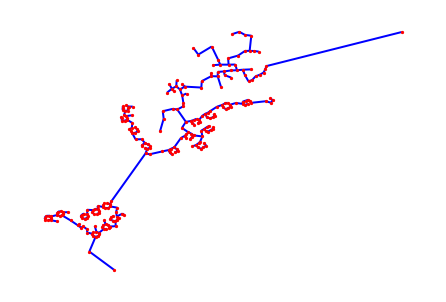

In [ ]:
rousys.min_spn_tre()

In [ ]:
inosys = inosys('wat_inv', ref_bus = 260)

In [ ]:
inosys.solve(solver = 'glpk')

GLPSOL: GLPK LP/MIP Solver, v4.65
Parameter(s) specified in the command line:
 --write /tmp/tmpha9jj71c.glpk.raw --wglp /tmp/tmp75qfre1p.glpk.glp --cpxlp
 /tmp/tmpl2riy2ew.pyomo.lp
Reading problem data from '/tmp/tmpl2riy2ew.pyomo.lp'...
59994 rows, 39103 columns, 166473 non-zeros
385566 lines were read
Writing problem data to '/tmp/tmp75qfre1p.glpk.glp'...
326038 lines were written
GLPK Simplex Optimizer, v4.65
59994 rows, 39103 columns, 166473 non-zeros
Preprocessing...
10366 rows, 10631 columns, 26443 non-zeros
Scaling...
 A: min|aij| =  6.192e-08  max|aij| =  1.000e+00  ratio =  1.615e+07
GM: min|aij| =  5.393e-01  max|aij| =  1.854e+00  ratio =  3.438e+00
EQ: min|aij| =  2.917e-01  max|aij| =  1.000e+00  ratio =  3.428e+00
Constructing initial basis...
Size of triangular part is 10366
      0: obj =   4.790735724e+11 inf =   2.517e+06 (2787)
  16430: obj =   4.790735724e+11 inf =   3.843e+03 (33) 90
  19898: obj =   4.790735724e+11 inf =   4.893e-12 (0) 2
OPTIMAL LP SOLUTION FOUND